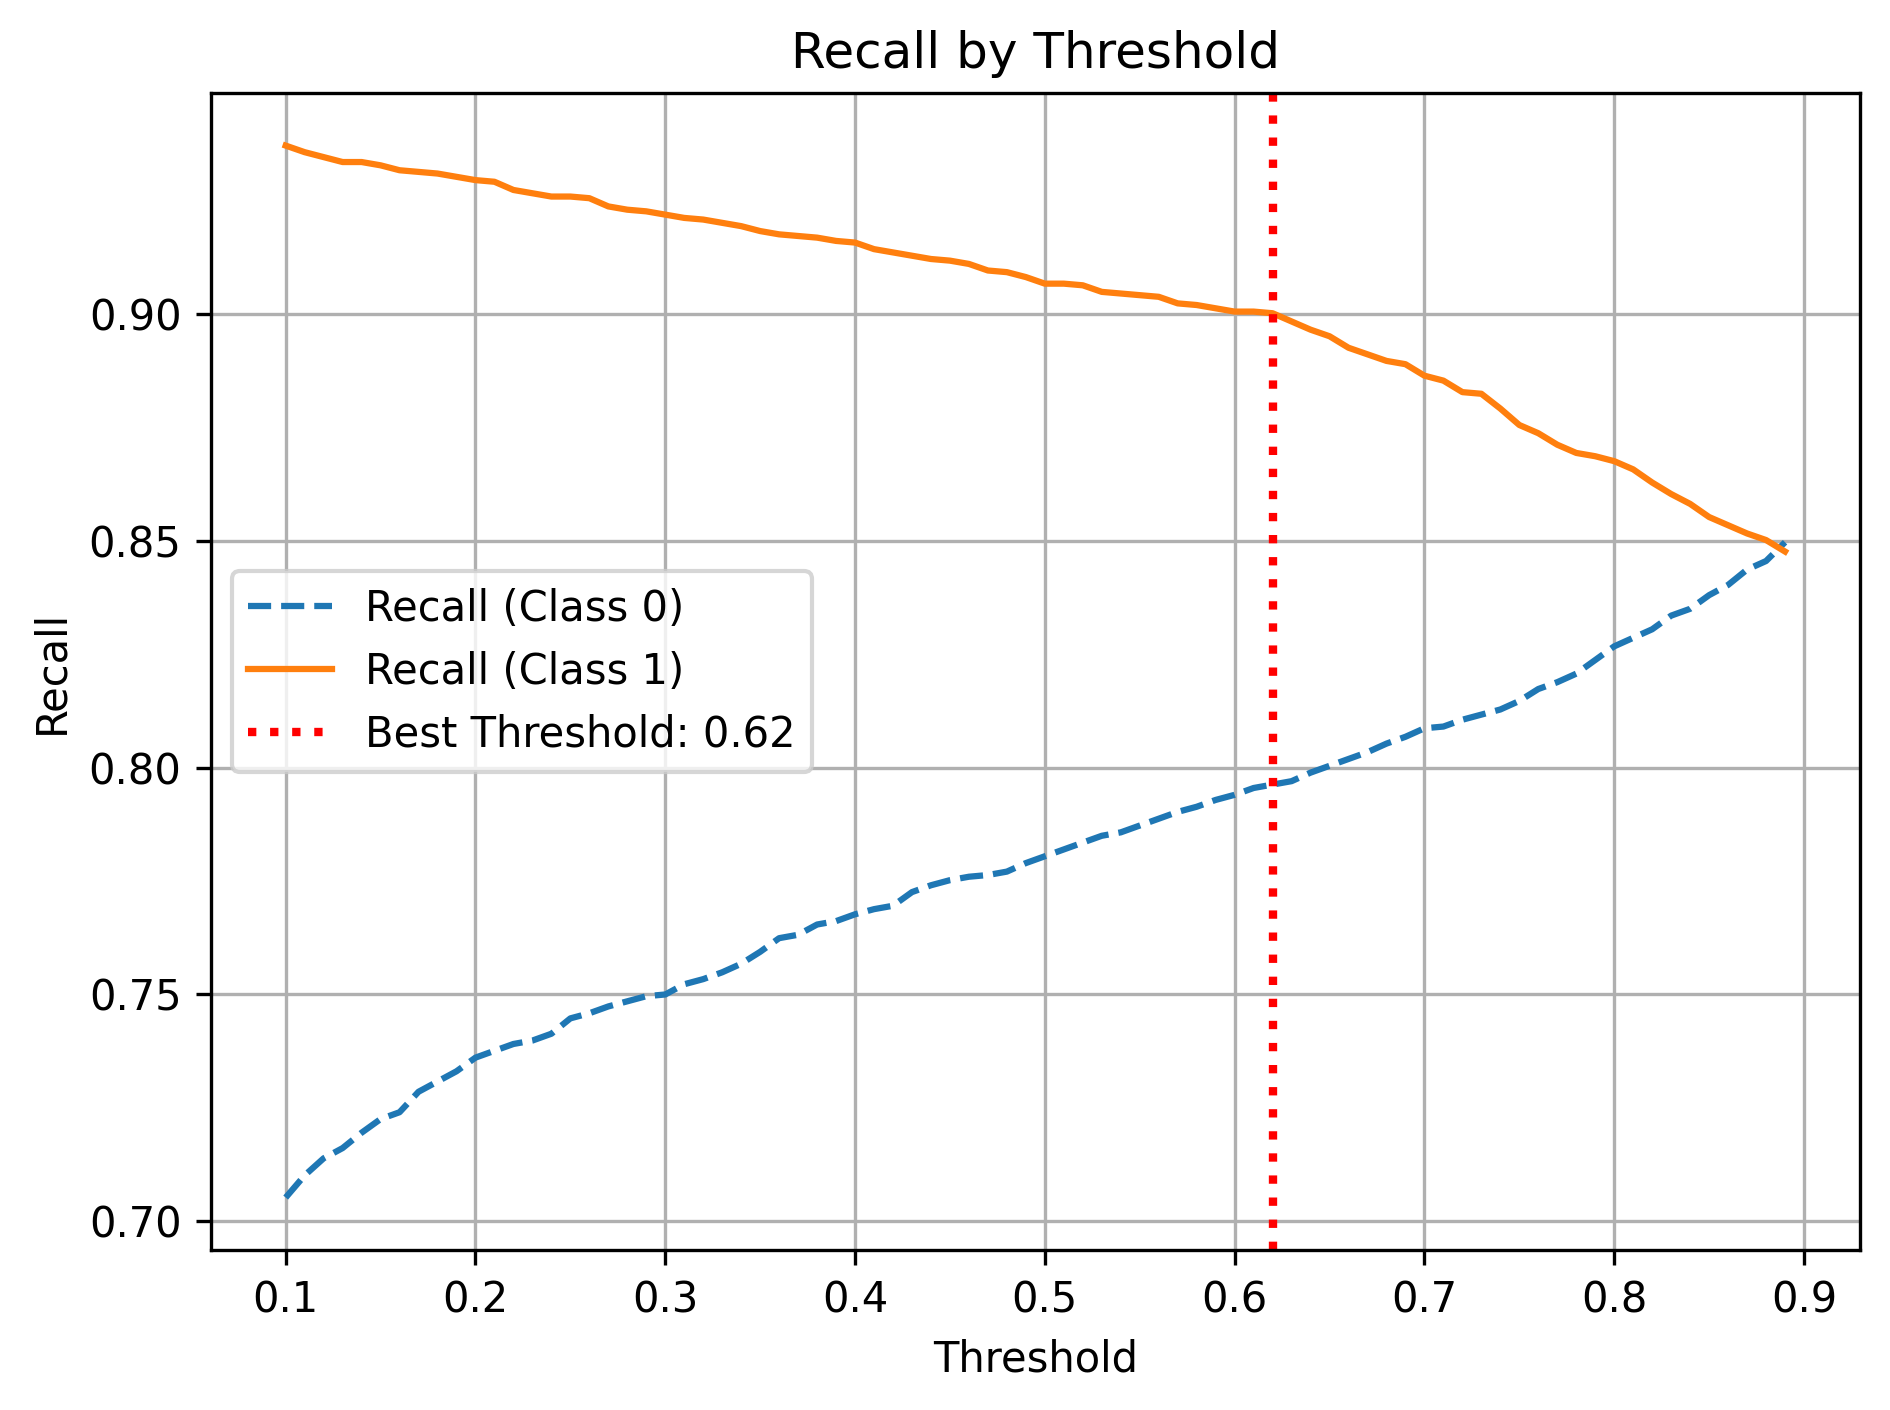

In [2]:
import matplotlib.pyplot as plt
import numpy as np

thresholds = np.arange(0.1, 0.9, 0.01)
recalls_0 = []
recalls_1 = []

for t in thresholds:
    preds = (all_probs > t).astype(int)
    recall_0 = recall_score(all_targets, preds, pos_label=0)
    recall_1 = recall_score(all_targets, preds, pos_label=1)
    recalls_0.append(recall_0)
    recalls_1.append(recall_1)

# 그래프 그리기 및 저장
plt.figure(dpi=300)
plt.plot(thresholds, recalls_0, label="Recall (Class 0)", linestyle='--')
plt.plot(thresholds, recalls_1, label="Recall (Class 1)", linestyle='-')
plt.axvline(x=best_thresh, color='red', linestyle=':', linewidth=2, label=f"Best Threshold: {best_thresh:.2f}")
plt.title("Recall by Threshold")
plt.xlabel("Threshold")
plt.ylabel("Recall")
plt.legend()
plt.grid(True)
plt.tight_layout()

# ✅ 이미지 저장
plt.savefig("recall_by_threshold.png", dpi=300)  # 저장 위치 및 파일명 지정
plt.show()


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, classification_report, recall_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, recall_score, classification_report


# -----------------------
# Dataset 정의
# -----------------------
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values if isinstance(y, pd.Series) else y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()
        stride = 2 if downsample else 1
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample
        self.proj = (
            nn.Conv1d(in_channels, out_channels, 1, stride=stride) if downsample or in_channels!=out_channels else nn.Identity()
        )
    def forward(self, x):
        identity = self.proj(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)

class ImprovedCNN1DClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.initial_bn = nn.BatchNorm1d(input_dim)
        self.conv = nn.Sequential(
            nn.Conv1d(1, 64, 3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            ResidualBlock1D(64, 128, downsample=True),
            ResidualBlock1D(128, 256, downsample=True),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten(),
        )

        self.mlp = nn.Sequential(
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        return self.mlp(x)

# -----------------------
# 데이터 로드
# -----------------------
x_train = pd.read_csv("./x_train.csv")
y_train = pd.read_csv("./y_test.csv")

# 클래스 정수형 확인
y_train = y_train.squeeze()
y_train = y_train.astype(int)

# 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x_train)

# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_train)

# 훈련/검증 분리
X_train, X_val, y_train_split, y_val = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42)

train_dataset = TabularDataset(X_train, y_train_split)
val_dataset = TabularDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True) #->64->128
val_loader = DataLoader(val_dataset, batch_size=256) # 64->128

# -----------------------
# 모델 설정
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedCNN1DClassifier(input_dim=x_train.shape[1]).to(device)

# pos_weight 계산
labels = np.unique(y_train_split)
class_weights = compute_class_weight(class_weight='balanced', classes=labels, y=y_train_split)
weight_dict = dict(zip(labels, class_weights))
pos_weight = torch.tensor([weight_dict[1] / weight_dict[0]]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  ##4->3

train_losses =[]
val_losses =[]
accs = []

# -----------------------
# 학습
# -----------------------
num_epochs = 100

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 검증 손실
    # -----------------------
    # 평가
    # -----------------------
    model.eval()
    all_probs, all_targets = [], []
    thresholds = []
    recalls_0 = []
    recalls_1 = []
    accs = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.extend(probs)
            all_targets.extend(y_batch.numpy())

    all_probs = np.array(all_probs).flatten()
    all_targets = np.array(all_targets).flatten()

    # Threshold 튜닝
    best_f1, best_thresh = 0, 0
    for t in np.arange(0.1, 0.9, 0.01):
        preds = (all_probs > t).astype(int)
        f1 = f1_score(all_targets, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t

    # 최종 예측
    final_preds = (all_probs > best_thresh).astype(int)
    acc = accuracy_score(all_targets, final_preds)
    accs.append(acc)
    report = classification_report(all_targets, final_preds, digits=4)

    print(f"\n✅ Best Threshold: {best_thresh:.2f}")
    print(f"✅ Accuracy       : {acc:.4f}")
    print(f"✅ F1 Score       : {best_f1:.4f}")
    print(report)



✅ Best Threshold: 0.29
✅ Accuracy       : 0.5965
✅ F1 Score       : 0.6999
              precision    recall  f1-score   support

         0.0     0.7646    0.2564    0.3840      2660
         1.0     0.5634    0.9240    0.6999      2762

    accuracy                         0.5965      5422
   macro avg     0.6640    0.5902    0.5420      5422
weighted avg     0.6621    0.5965    0.5449      5422


✅ Best Threshold: 0.29
✅ Accuracy       : 0.6079
✅ F1 Score       : 0.7076
              precision    recall  f1-score   support

         0.0     0.7921    0.2722    0.4051      2660
         1.0     0.5705    0.9312    0.7076      2762

    accuracy                         0.6079      5422
   macro avg     0.6813    0.6017    0.5564      5422
weighted avg     0.6792    0.6079    0.5592      5422


✅ Best Threshold: 0.36
✅ Accuracy       : 0.6197
✅ F1 Score       : 0.7083
              precision    recall  f1-score   support

         0.0     0.7679    0.3222    0.4539      2660
         

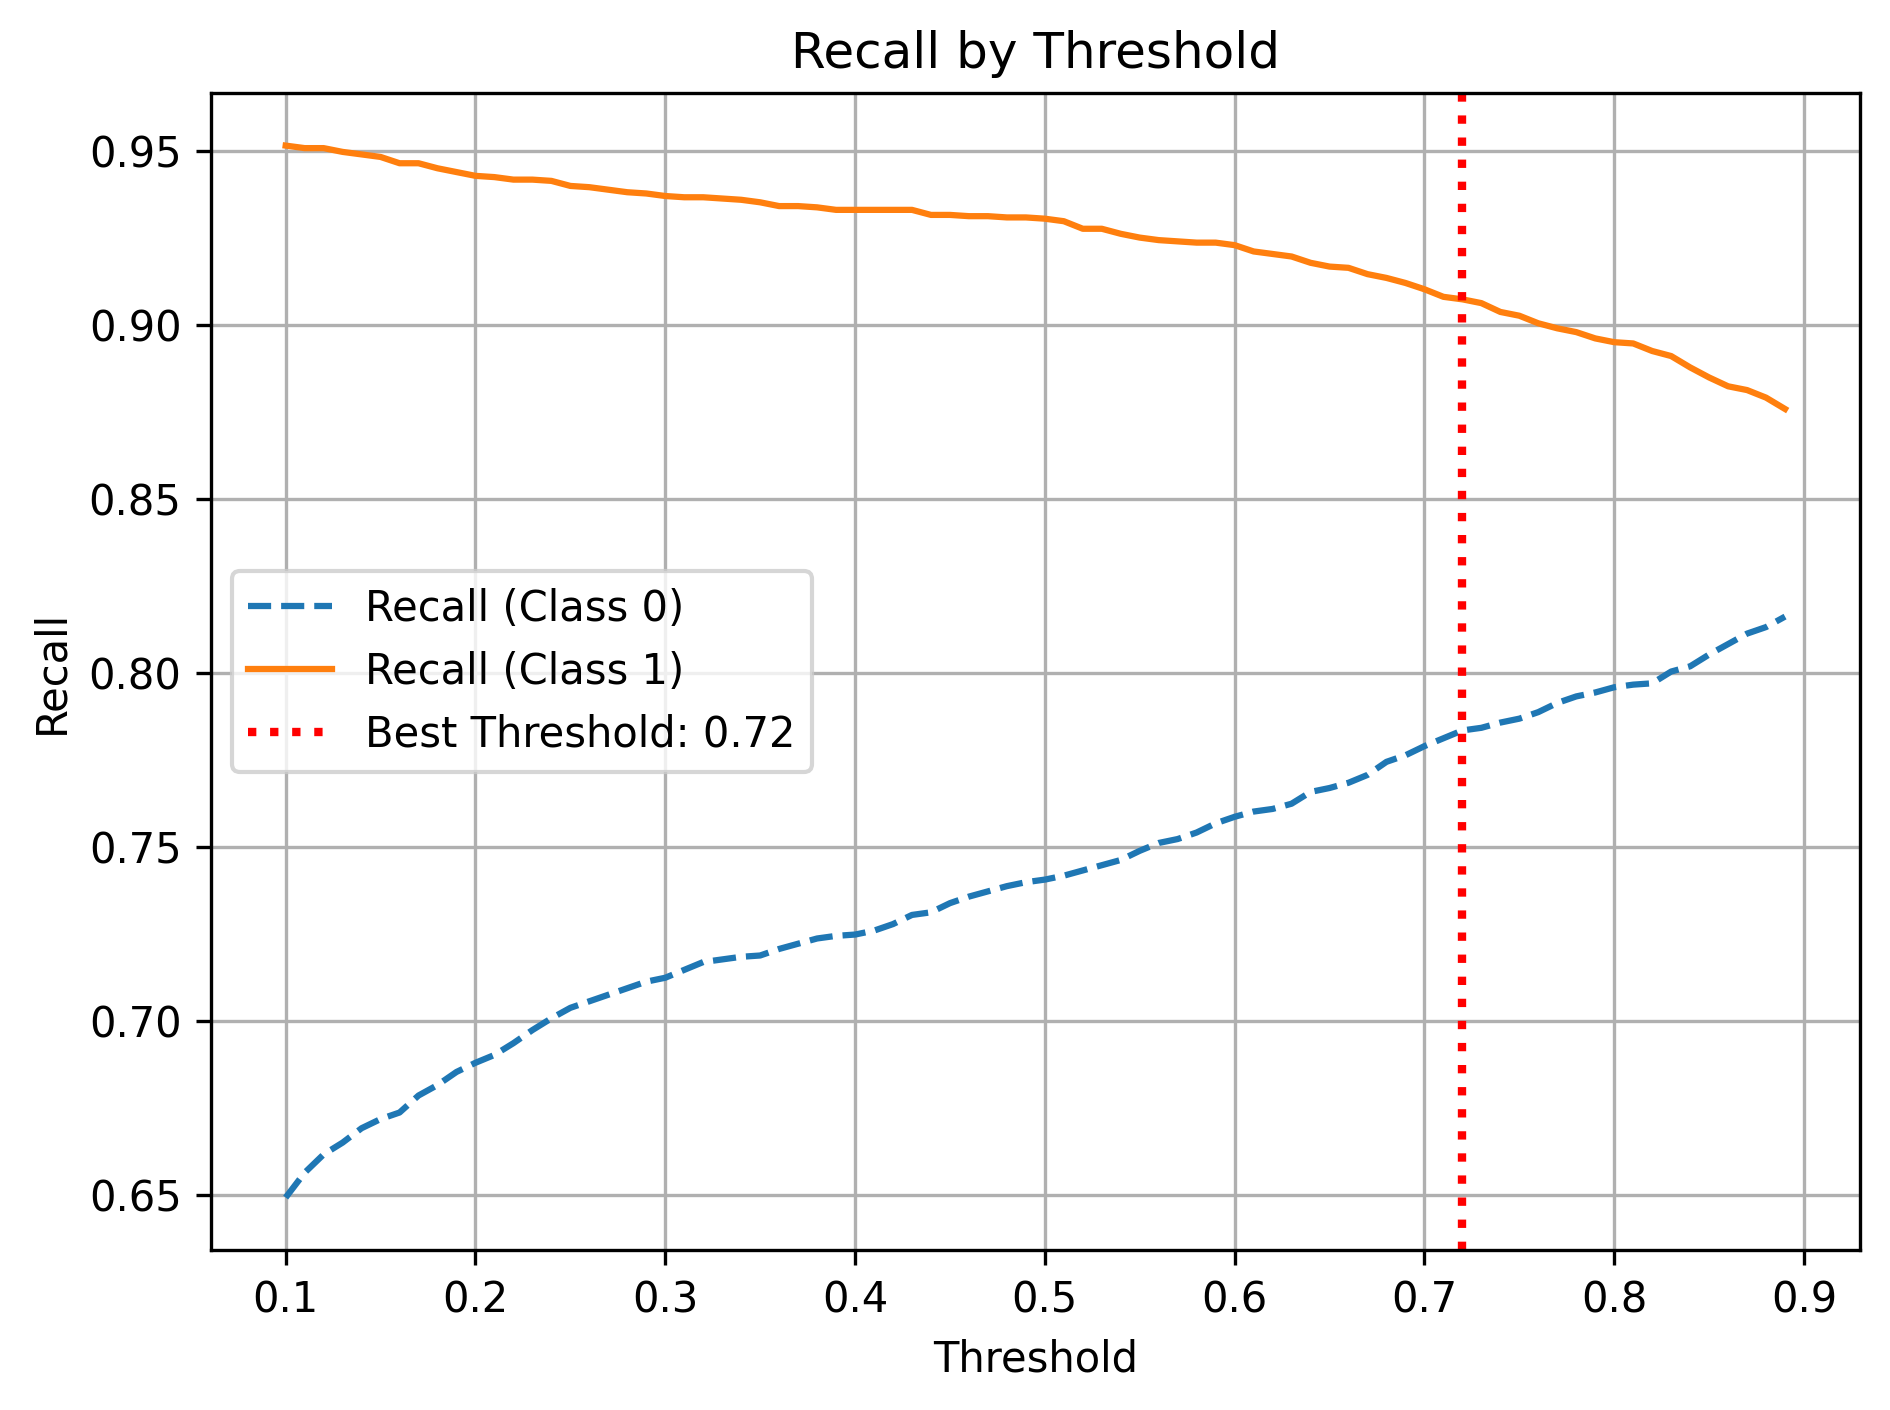

In [5]:
import matplotlib.pyplot as plt
import numpy as np

thresholds = np.arange(0.1, 0.9, 0.01)
recalls_0 = []
recalls_1 = []

for t in thresholds:
    preds = (all_probs > t).astype(int)
    recall_0 = recall_score(all_targets, preds, pos_label=0)
    recall_1 = recall_score(all_targets, preds, pos_label=1)
    recalls_0.append(recall_0)
    recalls_1.append(recall_1)

# 그래프 그리기 및 저장
plt.figure(dpi=300)
plt.plot(thresholds, recalls_0, label="Recall (Class 0)", linestyle='--')
plt.plot(thresholds, recalls_1, label="Recall (Class 1)", linestyle='-')
plt.axvline(x=best_thresh, color='red', linestyle=':', linewidth=2, label=f"Best Threshold: {best_thresh:.2f}")
plt.title("Recall by Threshold")
plt.xlabel("Threshold")
plt.ylabel("Recall")
plt.legend()
plt.grid(True)
plt.tight_layout()

# ✅ 이미지 저장
plt.savefig("recall_by_threshold.png", dpi=300)  # 저장 위치 및 파일명 지정
plt.show()


In [20]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, classification_report, recall_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# -----------------------
# Dataset 정의
# -----------------------
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values if isinstance(y, pd.Series) else y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()
        stride = 2 if downsample else 1
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.proj = nn.Conv1d(in_channels, out_channels, 1, stride=stride) if downsample or in_channels != out_channels else nn.Identity()

    def forward(self, x):
        identity = self.proj(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)

class ImprovedCNN1DClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.initial_bn = nn.BatchNorm1d(input_dim)
        self.conv = nn.Sequential(
            nn.Conv1d(1, 64, 3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            ResidualBlock1D(64, 128, downsample=True),
            ResidualBlock1D(128, 256, downsample=True),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten(),
        )
        self.mlp = nn.Sequential(
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        return self.mlp(x)

# -----------------------
# 데이터 로드
# -----------------------
x_train = pd.read_csv("./x_train.csv")
y_train = pd.read_csv("./y_test.csv")

# 클래스 정수형 확인
y_train = y_train.squeeze()
y_train = y_train.astype(int)

# 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x_train)

# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_train)

# 훈련/검증 분리
X_train, X_val, y_train_split, y_val = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42)

train_dataset = TabularDataset(X_train, y_train_split)
val_dataset = TabularDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256)

# -----------------------
# 모델 설정
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedCNN1DClassifier(input_dim=x_train.shape[1]).to(device)

# pos_weight 계산
labels = np.unique(y_train_split)
class_weights = compute_class_weight(class_weight='balanced', classes=labels, y=y_train_split)
weight_dict = dict(zip(labels, class_weights))
pos_weight = torch.tensor([weight_dict[1] / weight_dict[0]]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# -----------------------
# 기록용 변수
# -----------------------
train_losses = []
val_losses = []
accs = []

# -----------------------
# 학습
# -----------------------
num_epochs = 100

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 검증 손실 및 정확도
    model.eval()
    total_val_loss = 0
    all_probs, all_targets = [], []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            val_loss = criterion(logits, y_batch)
            total_val_loss += val_loss.item()

            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.extend(probs)
            all_targets.extend(y_batch.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    all_probs = np.array(all_probs).flatten()
    all_targets = np.array(all_targets).flatten()

    best_f1, best_thresh = 0, 0
    for t in np.arange(0.1, 0.9, 0.01):
        preds = (all_probs > t).astype(int)
        f1 = f1_score(all_targets, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t

    final_preds = (all_probs > best_thresh).astype(int)
    acc = accuracy_score(all_targets, final_preds)
    accs.append(acc)

    print(f"\n✅ Epoch {epoch}")
    print(f" - Train Loss     : {avg_train_loss:.4f}")
    print(f" - Val Loss       : {avg_val_loss:.4f}")
    print(f" - Val Accuracy   : {acc:.4f}")
    print(f" - Best Threshold : {best_thresh:.2f}")
    print(f" - F1 Score       : {best_f1:.4f}")



✅ Epoch 1
 - Train Loss     : 0.6492
 - Val Loss       : 0.6355
 - Val Accuracy   : 0.5990
 - Best Threshold : 0.36
 - F1 Score       : 0.7019

✅ Epoch 2
 - Train Loss     : 0.6295
 - Val Loss       : 0.6264
 - Val Accuracy   : 0.6075
 - Best Threshold : 0.29
 - F1 Score       : 0.7109

✅ Epoch 3
 - Train Loss     : 0.6192
 - Val Loss       : 0.6202
 - Val Accuracy   : 0.6241
 - Best Threshold : 0.37
 - F1 Score       : 0.7106

✅ Epoch 4
 - Train Loss     : 0.6102
 - Val Loss       : 0.6128
 - Val Accuracy   : 0.6293
 - Best Threshold : 0.32
 - F1 Score       : 0.7160

✅ Epoch 5
 - Train Loss     : 0.6016
 - Val Loss       : 0.6091
 - Val Accuracy   : 0.6557
 - Best Threshold : 0.42
 - F1 Score       : 0.7235

✅ Epoch 6
 - Train Loss     : 0.5889
 - Val Loss       : 0.5948
 - Val Accuracy   : 0.6568
 - Best Threshold : 0.35
 - F1 Score       : 0.7278

✅ Epoch 7
 - Train Loss     : 0.5746
 - Val Loss       : 0.5896
 - Val Accuracy   : 0.6634
 - Best Threshold : 0.37
 - F1 Score       :

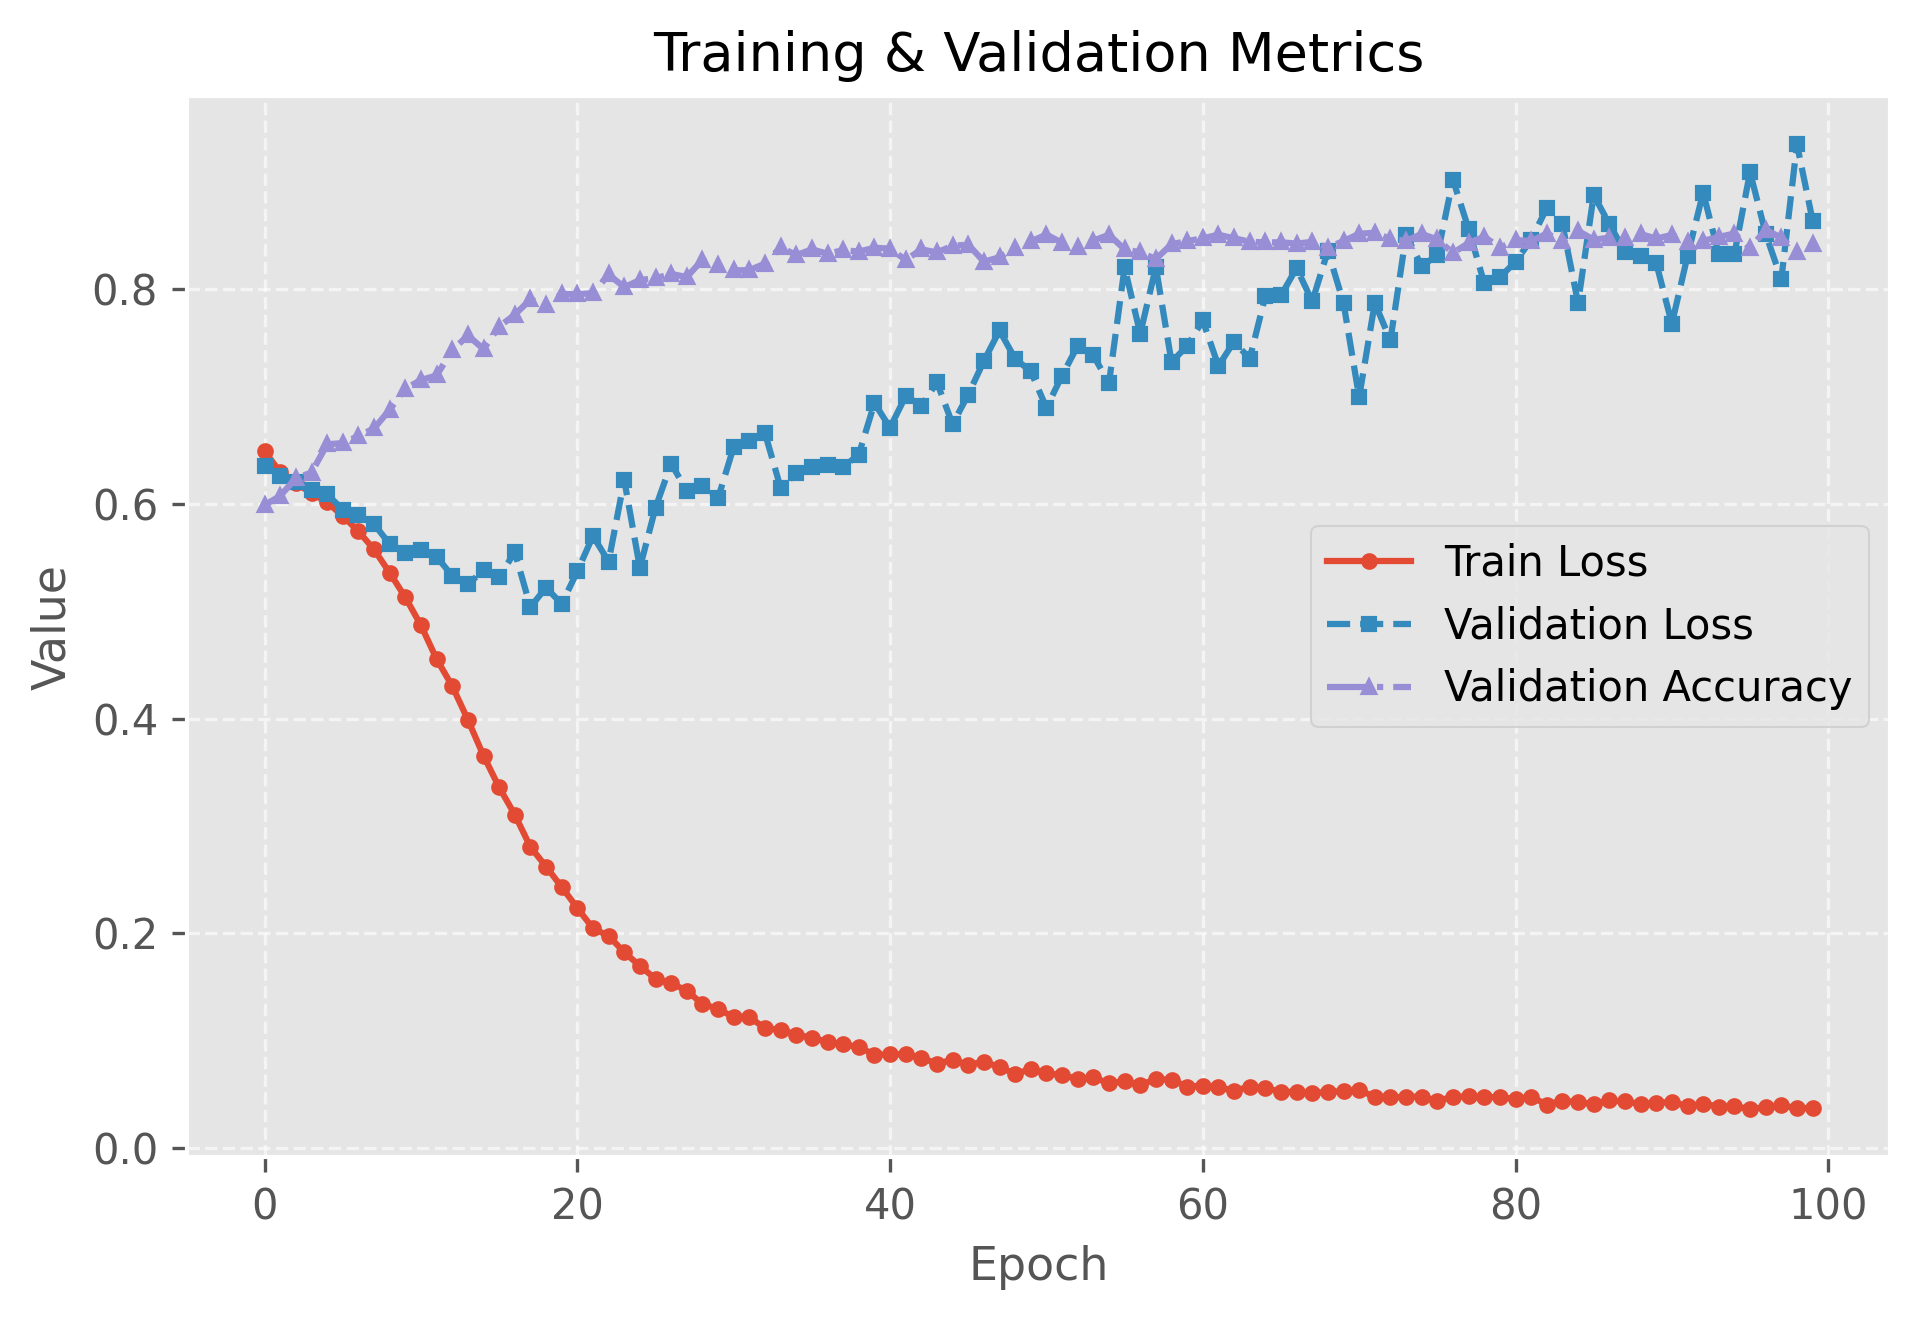

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6.5, 4.5), dpi=300)
plt.plot(train_losses, label='Train Loss', linestyle='-', marker='o', markersize=3)
plt.plot(val_losses, label='Validation Loss', linestyle='--', marker='s', markersize=3)
plt.plot(accs, label='Validation Accuracy', linestyle='-.', marker='^', markersize=3)

plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Value', fontsize=11)
plt.title('Training & Validation Metrics', fontsize=13)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("training_val_metrics.png", dpi=300)
plt.show()


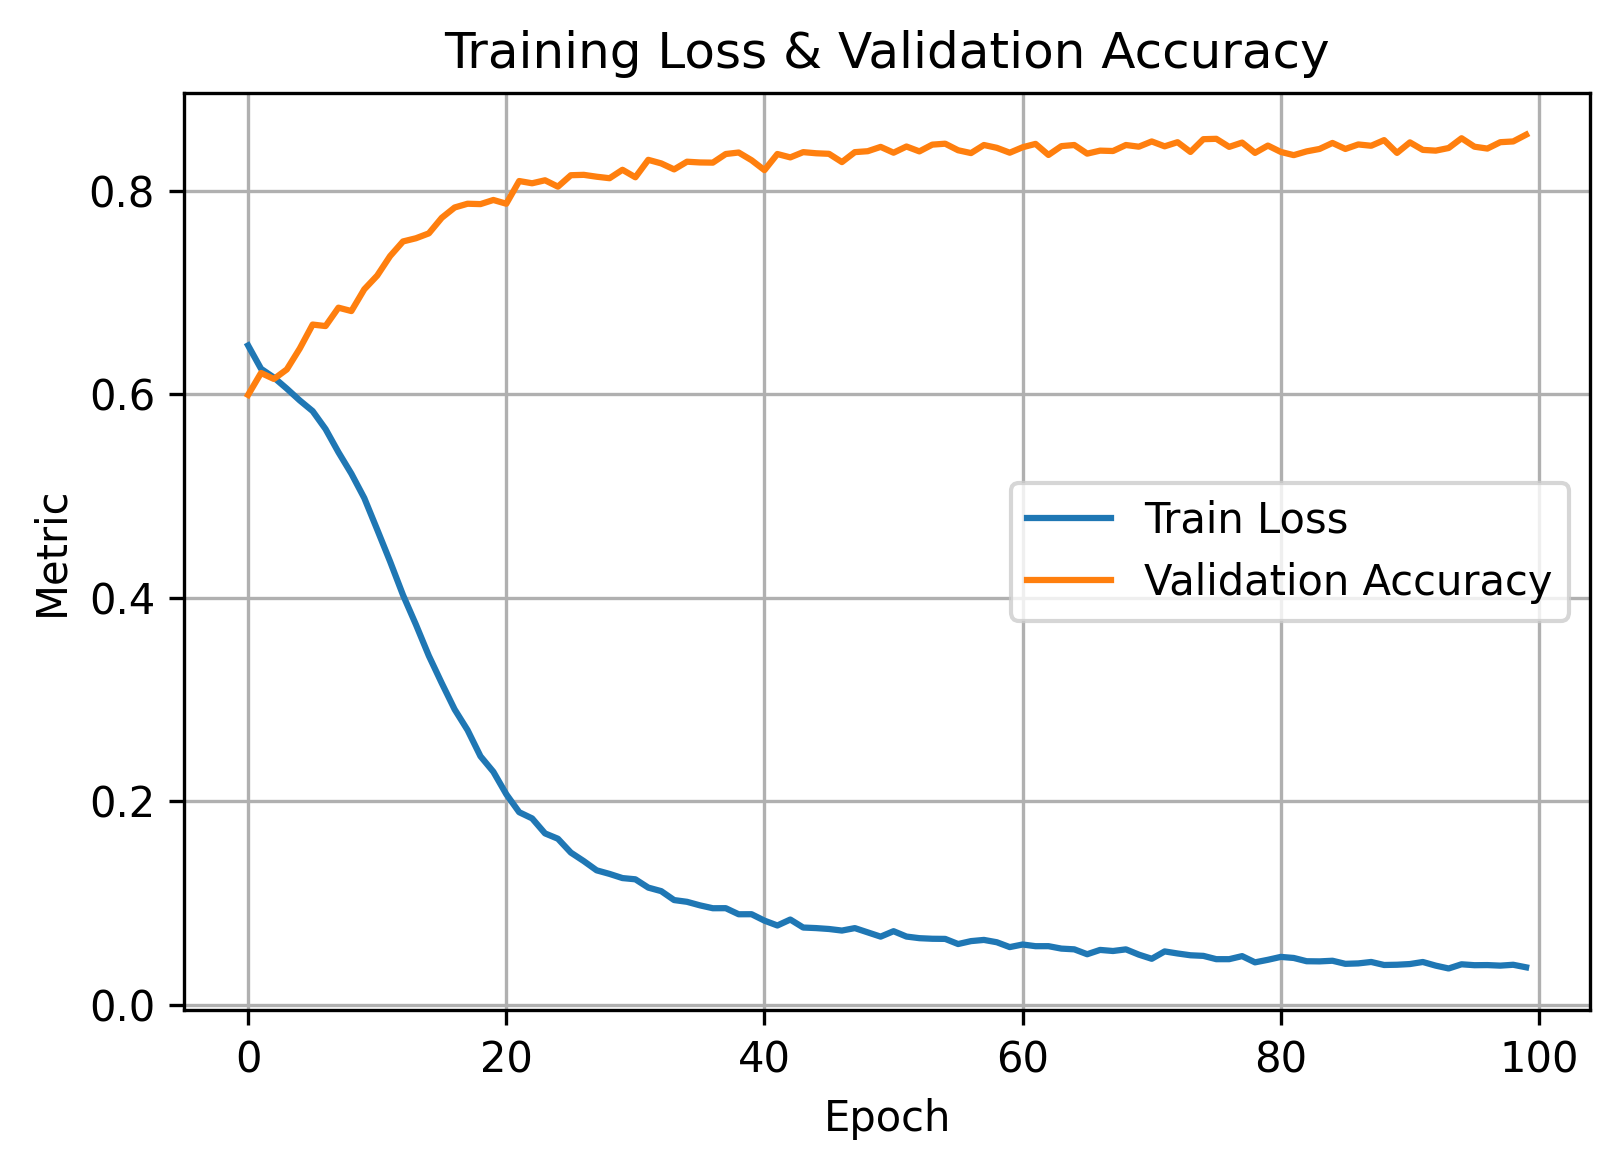

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5.5, 4), dpi=300)
plt.plot(train_losses, label='Train Loss')
plt.plot(accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Training Loss & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()

# ✅ 반드시 show() 전에 저장
plt.savefig('metrics_plot.png', dpi=300)

plt.show()  # 이후에 보여주기


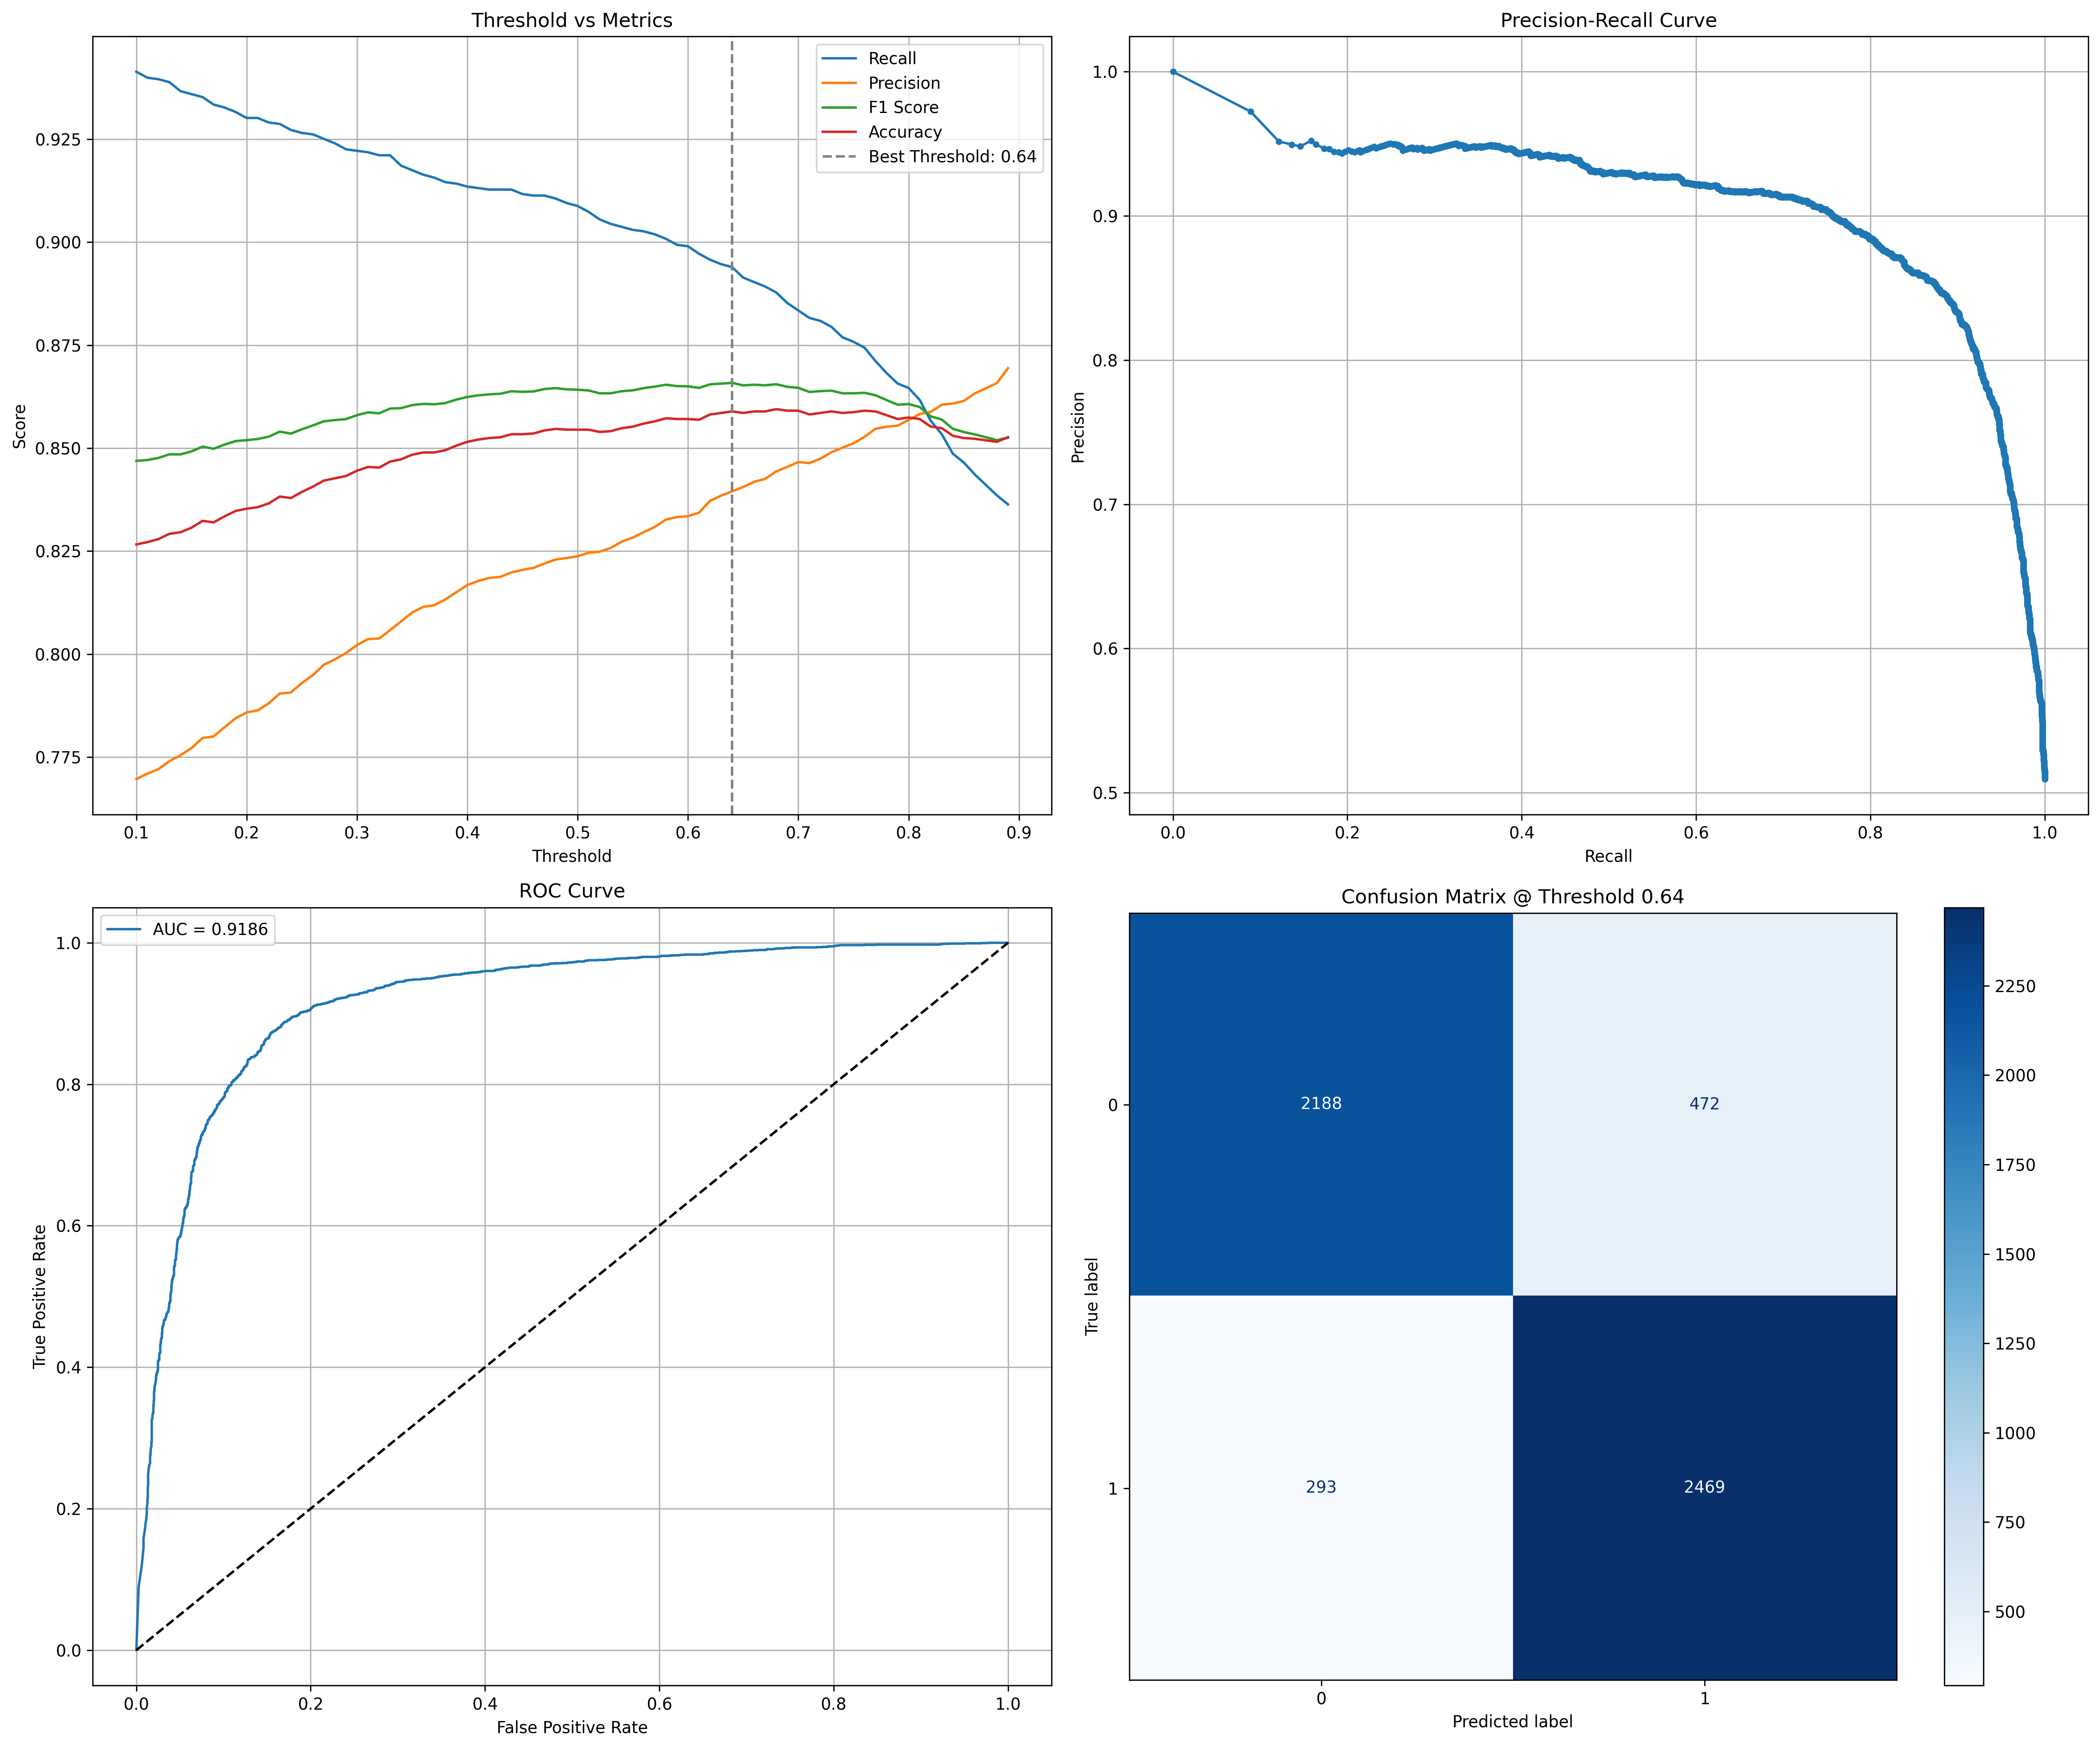

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, recall_score, precision_score, f1_score
)

# threshold 탐색
thresholds = np.arange(0.1, 0.9, 0.01)
recalls, precisions, f1s, accs = [], [], [], []

for t in thresholds:
    preds = (all_probs > t).astype(int)
    recalls.append(recall_score(all_targets, preds))
    precisions.append(precision_score(all_targets, preds))
    f1s.append(f1_score(all_targets, preds))
    accs.append(accuracy_score(all_targets, preds))

# Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(all_targets, all_probs)

# ROC Curve
fpr, tpr, _ = roc_curve(all_targets, all_probs)
roc_auc = auc(fpr, tpr)

# Confusion Matrix (Best threshold 기준)
best_thresh_idx = np.argmax(f1s)
best_threshold = thresholds[best_thresh_idx]
best_preds = (all_probs > best_threshold).astype(int)
cm = confusion_matrix(all_targets, best_preds)

# 시각화
plt.figure(figsize=(18, 15), dpi=300)

# 1. Threshold vs Metric
plt.subplot(2, 2, 1)
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, f1s, label='F1 Score')
plt.plot(thresholds, accs, label='Accuracy')
plt.axvline(best_threshold, color='gray', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.title('Threshold vs Metrics')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# 2. Precision-Recall Curve
plt.subplot(2, 2, 2)
plt.plot(recall_curve, precision_curve, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)

# 3. ROC Curve
plt.subplot(2, 2, 3)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)

# 4. Confusion Matrix
plt.subplot(2, 2, 4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(ax=plt.gca(), cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix @ Threshold {best_threshold:.2f}')

plt.tight_layout()
plt.show()
